In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import t

%matplotlib inline
plt.style.use('seaborn-white')

# Problem Set 6

Note: This is the `python` version of *EX6_bootstrapR.R*. 

## Exercise 1

Consider the following data generating process in which we have $n$ observations and one covariate $\mathbf{X}$ covariates
additional to a constant. $\mathbf{X} \sim \mathscr{N}_p(\mathbf{0}, \sigma^2)$. $\beta = (1, 1.5, \text{-}1.5, 1.5)$ and the errors are drawn from a normal distribution $\epsilon \sim N(0, 1)$. The model is generated by $y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \epsilon$.

**a)** Calculate the analytical standard errors for the polynomial specification above (as presented in the lecture)
and use these to calculate the approximate confidence intervals as $2 * SE$ for each value of $\mathbf{X}$ you consider.

In [2]:
# Simulate the OLS regression and plot the regeression line. #

# Preparatory work.
N = 200
x_1 = np.full((N,1), 1)
x_2 = np.random.normal(0, 1, N).reshape(-1, 1)
x = np.concatenate((x_1, x_2, x_2 ** 2, x_2 ** 3), axis=1)

In [3]:
# Add homoscedastic error term to make the final model.
eps = np.random.normal(0, 1, N)
beta_vec = np.array([1, 1.5, -1.5, 1.5])
y = x @ beta_vec + eps

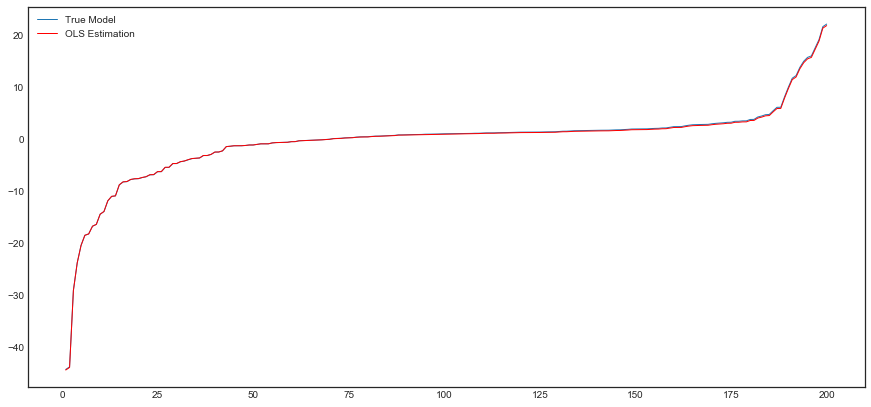

In [4]:
# Estimate the OLS estimator and plot the regression line.
beta_hat = np.linalg.solve(x.T @ x, x.T @ y)
x_grid = np.sort(x_2.reshape(-1,))  # Convienient for observing.

true_model_mean = beta_vec[0] + beta_vec[1] * x_grid + beta_vec[2] * (x_grid ** 2) + beta_vec[3] * (x_grid ** 3)
estim_model = beta_hat[0] + beta_hat[1] * x_grid + beta_hat[2] * (x_grid ** 2) + beta_hat[3] * (x_grid ** 3)
plot_x = np.arange(1, N+1)

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(plot_x, true_model_mean, label='True Model', lw=1)
ax.plot(plot_x, estim_model, label='OLS Estimation', color='red', lw=1)
ax.legend()

The following part is related to the variable in our interests: fitted response `y_hat`. To calculate the confidence interval (CI) of it, we have to estimate the variance of it. In this OLS regression situation the formula is:

\begin{equation}
Var(\hat{\mathbf{y}}) = \mathbf{X} Var(\hat{\mathbf{\beta}}) \mathbf{X}'
\end{equation}

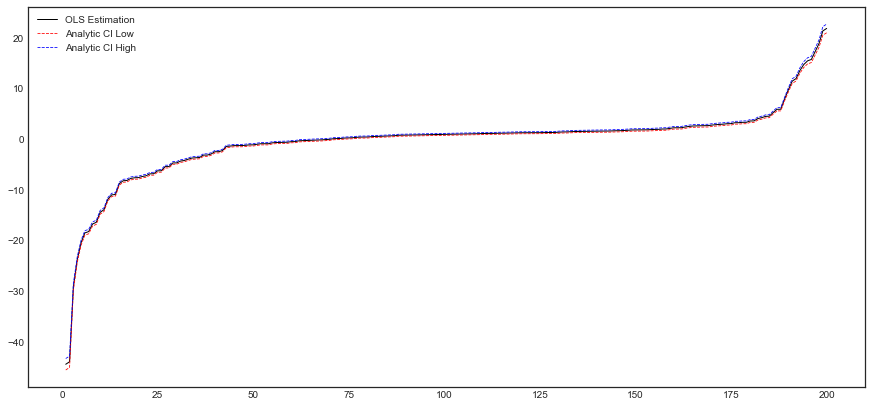

In [5]:
# Calculate the covariance matrix. #

# Fitted responses and residuals.
y_hat = x @ beta_hat
eps_hat = y - y_hat

# Calculate the cov.
se = (eps_hat @ eps_hat) / (N - x.shape[1] - 1)
cov = np.linalg.inv(x.T @ x) * se

# Calculate the variance of the fitted responses.
new_data = x[np.argsort(x[:, 1])]  # Reorder the whole data according to x_2.
cov_y_hat = new_data @ cov @ new_data.T
var = []
for i in np.arange(N):
    var.append(cov_y_hat[i, i])
var = np.array(var)

# Calculate the analytic CI.
d = 2 * np.sqrt(var)
conf_low = estim_model - d
conf_high = estim_model + d

# Replot
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(plot_x, estim_model, label='OLS Estimation', color='black', lw=1)
ax.plot(plot_x, conf_low, '--', label='Analytic CI Low', color='red', lw=0.8)
ax.plot(plot_x, conf_high, '--', label='Analytic CI High', color='blue', lw=0.8)
ax.legend()

In [6]:
# Bootstrap CI #

# Prepare for the iteration.
B = 200
b_sample = np.full((N, B), np.nan)
data = np.concatenate((y.reshape(-1, 1), x), axis=1)
function_B = np.full((N, B), np.nan)

In [7]:
# Bootstrap.
for i in np.arange(B):
    bsp_index = np.random.choice(N, size=N, replace=True)
    xB = data[bsp_index,:]
    beta_hat_temp = np.linalg.inv(xB[:, 1:].T @ xB[:, 1:]) @ xB[:, 1:].T @ xB[:,0]
    function_B[:, i] = beta_hat_temp[0] + beta_hat_temp[1] * x_grid + beta_hat_temp[2] * (x_grid ** 2) + beta_hat_temp[3] * (x_grid ** 3)

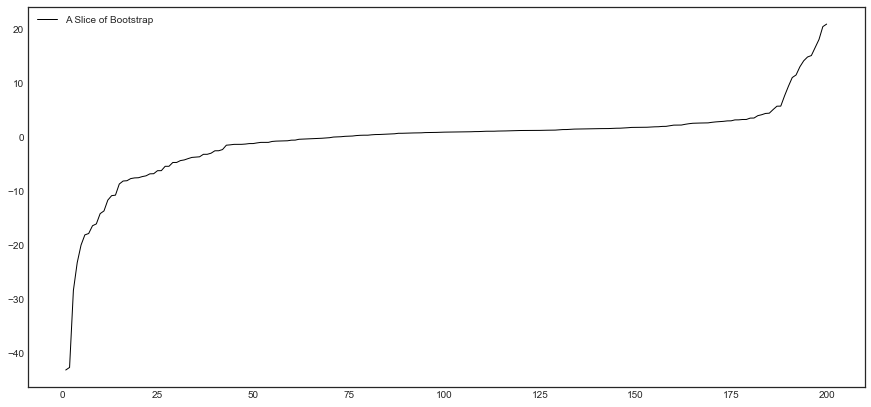

In [8]:
# Quick snap pf the bootstrap results.
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(plot_x, function_B[:, 0], label='A Slice of Bootstrap', color='black', lw=1)
ax.legend()

In [9]:
# Order the bootstrap experiments for quantiles.
function_B.sort(axis=1)

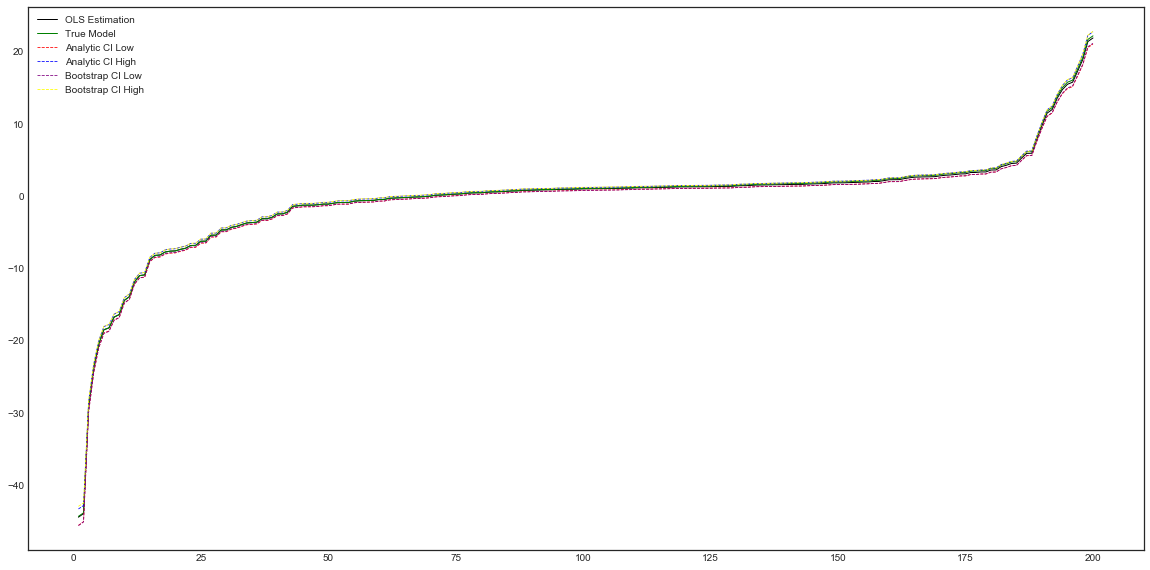

In [10]:
# Calculate the quantiles.
conf_highB = function_B[:, 194]
conf_lowB = function_B[:, 4]

# Plot all curves together.
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_x, estim_model, label='OLS Estimation', color='black', lw=1)
ax.plot(plot_x, true_model_mean, label='True Model', color='green', lw=1)
ax.plot(plot_x, conf_low, '--', label='Analytic CI Low', color='red', lw=0.8)
ax.plot(plot_x, conf_high, '--', label='Analytic CI High', color='blue', lw=0.8)
ax.plot(plot_x, conf_lowB, '--', label='Bootstrap CI Low', color='purple', lw=0.8)
ax.plot(plot_x, conf_highB, '--', label='Bootstrap CI High', color='yellow', lw=0.8)
ax.legend()

In [11]:
# Calculate the coverage probabilities.
cproba = np.mean((true_model_mean > conf_low) & (true_model_mean < conf_high))
cprobB = np.mean((true_model_mean > conf_lowB) & (true_model_mean < conf_highB))
print('The Coverage probability of ', '\n'
     'analytic CI is {},'.format(cproba), '\n'
     'bootstrap CI is {}'.format(cprobB))

The Coverage probability of  
analytic CI is 1.0, 
bootstrap CI is 1.0


**Remark:** We will repeat this experiment later in order to obtain more stable probabilities.

In [12]:
# Calculate the interval length.
int_length =np.mean(conf_high - conf_low)
int_lengthB = np.mean(conf_highB - conf_lowB)
longerB = sum(((conf_highB - conf_lowB) / (conf_high - conf_low)) > 1)
print('The avg. interval length of ', '\n'
     'analytic CI is {},'.format(int_length), '\n'
     'bootstrap CI is {}'.format(int_lengthB))
print('There are {} times when the interval length of bootstrap is larger than the analytic one.'.format(longerB))

The avg. interval length of  
analytic CI is 0.5495173524842384, 
bootstrap CI is 0.5634481894824986
There are 130 times when the interval length of bootstrap is larger than the analytic one.


## Exercise 2

Evaluate the two types of confidence intervals above along two dimensions: interval length and coverage probability.

* Calculate both for a small simulation study of 100 repetitions.
* How could you change the data-generating process to give a competitive advantage to the bootstrap? Suggest two changes and check each in a simulation study.

First we do a short summary of our model candidates:

* **Model 1:**　　$\epsilon \sim N(0,10)$
* **Model 2:**　　$\epsilon \sim \Gamma(0.1, 0.01)$ and $\epsilon$ is centered.
* **Model 3:**　　$\epsilon \sim x_2^2 * N(0, 10)$ (Heteroscedastic error term)
* **Model 4:**　　Mixture Model
* **Model 5:**　　$\epsilon \sim t(1)$
* **Model 6:**　　$\epsilon \sim U([-1, 1])$

In [13]:
# Amounts to the scale() function in R.
def r_scale(arr, c=True, sc=True):
    """
    Use root-mean-square method to scale the data. If both c and sc are False,
    the input array will be directly printed out without any change.
    Input:
        arr (array-like): An array needed to be centered or scaled or both.
        c (bool): Center or not? (Default=True)
        sc (bool): Scale or not? (Default=True)
    Output:
        arr_f (np.ndarray): Data after being processed.
    """
    if c == False and sc == False:
        return arr
    
    arr = np.array(arr)
    arr_f = arr.astype(float)
    if c:
        arr_f -= arr_f.mean()
    if sc:
        arr_f /= np.sqrt(sum(arr_f ** 2) / (arr_f.shape[0] - 1))
    
    return arr_f

In [14]:
# Write a function using the previous procedure to encapsulate bootstrap. Add model selection parts.

# Parameters adjustments
N = 200
B = 200
alpha = 0.05
x_1 = np.full((N, 1), 1)
x_2 = np.random.normal(0, 1, N).reshape(-1, 1)
x = np.concatenate((x_1, x_2, x_2 ** 2, x_2 ** 3), axis=1)

def model_selection(model, sample_size):
    """
    Use a model to generate error terms.
    Input:
        model (int): 1 between 6, see Markdown part.
        sample_size (int): Sample size.
    Output:
        eps (np.ndarray): Error terms vector.
    """
    if model == 1:
        eps = np.random.normal(0, 10, sample_size)
    if model == 2:
        eps = np.random.gamma(0.1, 0.01, sample_size)
        eps = r_scale(eps, sc=False)  
    if model == 3:
        eps = np.multiply((x_2 ** 2).reshape(-1,), np.random.normal(0, 10, sample_size))
    if model == 4:
        # Sample uniform distribution.
        U = np.random.uniform(size=sample_size)
        # Mixture model.
        eps = np.full((sample_size,), np.nan)
        for i in np.arange(sample_size):
            if U[i] < 0.3:
                eps[i] = np.random.normal(-5.9, 1, 1)
            elif U[i] < 0.8:
                eps[i] = np.random.normal(4.1,1, 1)
            else:
                eps[i] = np.random.normal(-1.9, 0.1, 1)
    if model == 5:
        eps = t.rvs(1, size=sample_size)
    if model == 6:
        eps = np.random.uniform(-1, 1, sample_size)
    
    return eps

In [15]:
# Figure function.
def plot_eps(model, sample_size):
    """
    How the error term densities look like.
    """
    err = model_selection(model, sample_size)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = sns.distplot(err, bins=30)
    ax.set_ylabel('Density')
    ax.set_title('Model {}'.format(model))

Review our 6 models:
* **Model 1:**　　$\epsilon \sim N(0,10)$
* **Model 2:**　　$\epsilon \sim \Gamma(0.1, 0.01)$ and $\epsilon$ is centered.
* **Model 3:**　　$\epsilon \sim x_2^2 * N(0, 10)$ (Heteroscedastic error term)
* **Model 4:**　　Mixture Model
* **Model 5:**　　$\epsilon \sim t(1)$
* **Model 6:**　　$\epsilon \sim U([-1, 1])$

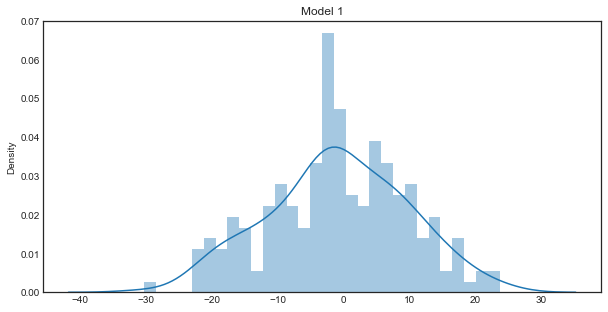

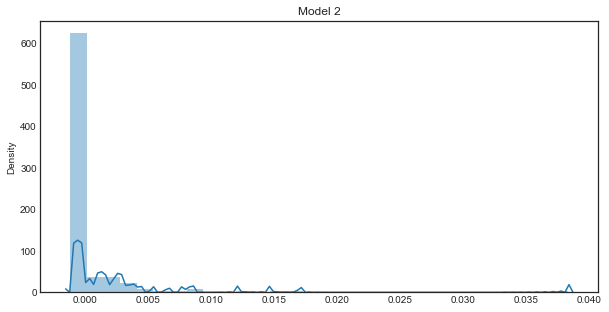

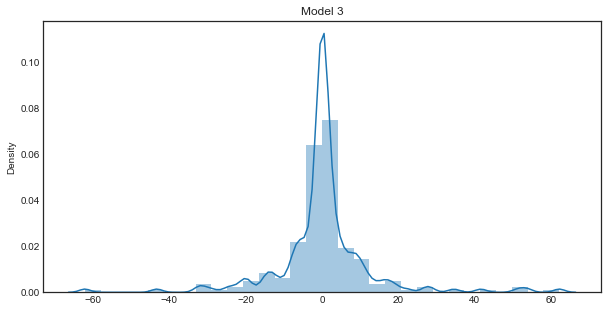

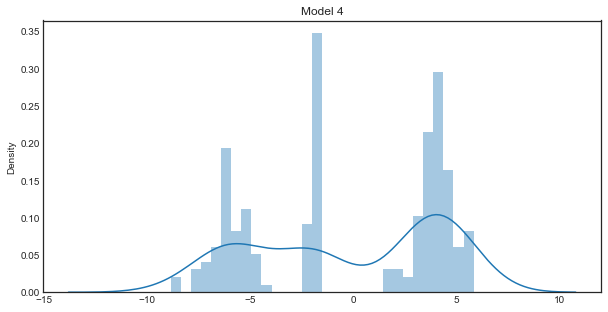

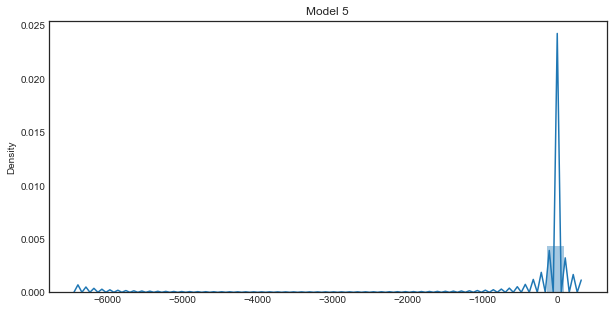

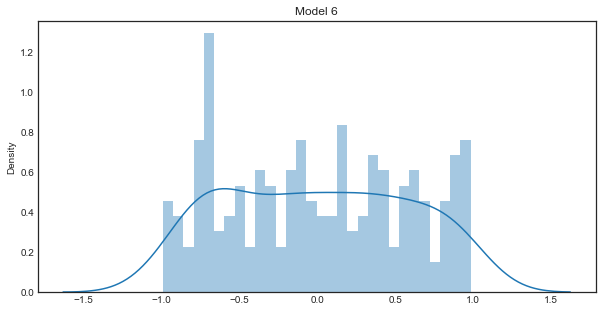

In [16]:
for model in (np.arange(6) + 1):
    plot_eps(model, N)

In [17]:
# Bootstrap function for CI.
def data_conf(model, sample_size, boots_size):
    """
    Produce the report about the CI of analytic and bootstrap method.
    Input:
        model (int): 1 between 6, see Markdown part.
        sample_size (int): Sample size.
        boots_size (int): Bootstrap repeat times
    Output:
        CI_dict (dict): Dictionary in which CI bounds are stored.
        report_dict (dict): Some facts we are interested in about CI.
    """
    # Add error terms according to the model selected.
    eps = model_selection(model, sample_size)
    beta_vec = np.array([1, 1.5, -1.5, 1.5])
    y = x @ beta_vec + eps

    # Estimate the OLS estimator and plot the regression line.
    beta_hat = np.linalg.solve(x.T @ x, x.T @ y)
    x_grid = np.sort(x_2.reshape(-1,))  # Convienient for observing.

    true_model_mean = beta_vec[0] + beta_vec[1] * x_grid + beta_vec[2] * (x_grid ** 2) + beta_vec[3] * (x_grid ** 3)
    estim_model = beta_hat[0] + beta_hat[1] * x_grid + beta_hat[2] * (x_grid ** 2) + beta_hat[3] * (x_grid ** 3)

    # Calculate the covariance matrix. #

    # Fitted responses and residuals.
    y_hat = x @ beta_hat
    eps_hat = y - y_hat

    # Calculate the cov.
    se = (eps_hat @ eps_hat) / (sample_size - x.shape[1] - 1)
    cov = np.linalg.inv(x.T @ x) * se

    # Calculate the variance of the fitted responses.
    new_data = x[np.argsort(x[:, 1])]  # Reorder the whole data according to x_2.
    cov_y_hat = new_data @ cov @ new_data.T
    var = []
    for i in np.arange(sample_size):
        var.append(cov_y_hat[i, i])
    var = np.array(var)

    # Calculate the analytic CI.
    d = 2 * np.sqrt(var)
    conf_low = estim_model - d
    conf_high = estim_model + d

    # Bootstrap CI #

    # Prepare for the iteration.
    b_sample = np.full((sample_size, boots_size), np.nan)
    data = np.concatenate((y.reshape(-1, 1), x), axis=1)
    function_B = np.full((sample_size, boots_size), np.nan)

    # Bootstrap.
    for i in np.arange(boots_size):
        bsp_index = np.random.choice(sample_size,size=sample_size, replace=True)
        xB = data[bsp_index,:]
        beta_hat_temp = np.linalg.inv(xB[:, 1:].T @ xB[:, 1:]) @ xB[:, 1:].T @ xB[:,0]
        function_B[:, i] = beta_hat_temp[0] + beta_hat_temp[1] * x_grid + beta_hat_temp[2] * (x_grid ** 2) + beta_hat_temp[3] * (x_grid ** 3)

    # Order the bootstrap experiments for quantiles.
    function_B.sort(axis=1)

    # Calculate the quantiles.
    conf_highB = function_B[:, int((sample_size - sample_size * (alpha/2)) - 1)]
    conf_lowB = function_B[:, int(sample_size * (alpha/2) - 1)]

    # Calculate the coverage probabilities.
    cproba = np.mean((true_model_mean > conf_low) & (true_model_mean < conf_high))
    cprobB = np.mean((true_model_mean > conf_lowB) & (true_model_mean < conf_highB))

    # Calculate the interval length.
    int_length =np.mean(conf_high - conf_low)
    int_lengthB = np.mean(conf_highB - conf_lowB)
    longerB = np.mean(((conf_highB - conf_lowB) / (conf_high - conf_low)) > 1)
    
    
    reg_dict = {'true': true_model_mean, 'estim':estim_model}
    
    CI_dict = {'ci_low': conf_low, 'ci_high': conf_high,
              'ci_lowB': conf_lowB, 'ci_highB': conf_highB}

    report_dict = {'longerB': longerB, 'cov_probB': cprobB, 
                  'cov_prob_true': cproba, 'int_length': int_length, 
                  'int_lengthB': int_lengthB}
    
    return CI_dict, report_dict, reg_dict

In [18]:
# Plot CI for different models
def plot_models(model, sample_size, boots_size):
    ci, _, reg = data_conf(model, sample_size, boots_size)
    estim_model = reg['estim']
    true_model_mean = reg['true']
    conf_low = ci['ci_low']
    conf_high = ci['ci_high']
    conf_lowB = ci['ci_lowB']
    conf_highB = ci['ci_highB']
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(plot_x, estim_model, label='OLS Estimation', color='black', lw=1)
    ax.plot(plot_x, true_model_mean, label='True Model', color='green', lw=1)
    ax.plot(plot_x, conf_low, '--', label='Analytic CI Low', color='red', lw=0.8)
    ax.plot(plot_x, conf_high, '--', label='Analytic CI High', color='blue', lw=0.8)
    ax.plot(plot_x, conf_lowB, '--', label='Bootstrap CI Low', color='purple', lw=0.8)
    ax.plot(plot_x, conf_highB, '--', label='Bootstrap CI High', color='yellow', lw=0.8)
    ax.set_title('Model {}'.format(model))
    ax.legend()

Review our 6 models:
* **Model 1:**　　$\epsilon \sim N(0,10)$
* **Model 2:**　　$\epsilon \sim \Gamma(0.1, 0.01)$ and $\epsilon$ is centered.
* **Model 3:**　　$\epsilon \sim x_2^2 * N(0, 10)$ (Heteroscedastic error term)
* **Model 4:**　　Mixture Model
* **Model 5:**　　$\epsilon \sim t(1)$
* **Model 6:**　　$\epsilon \sim U([-1, 1])$

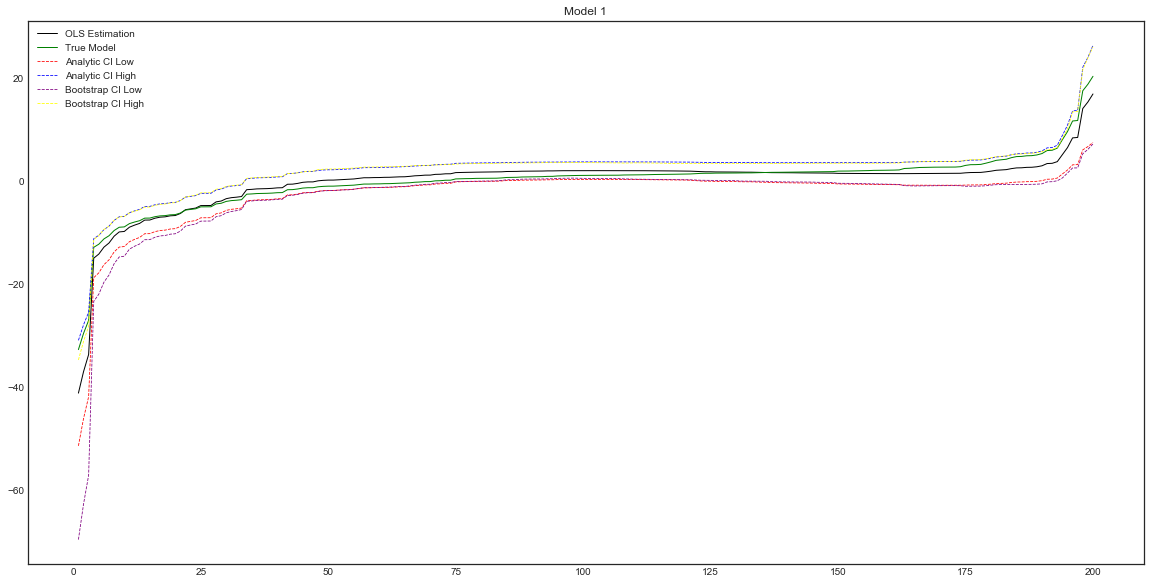

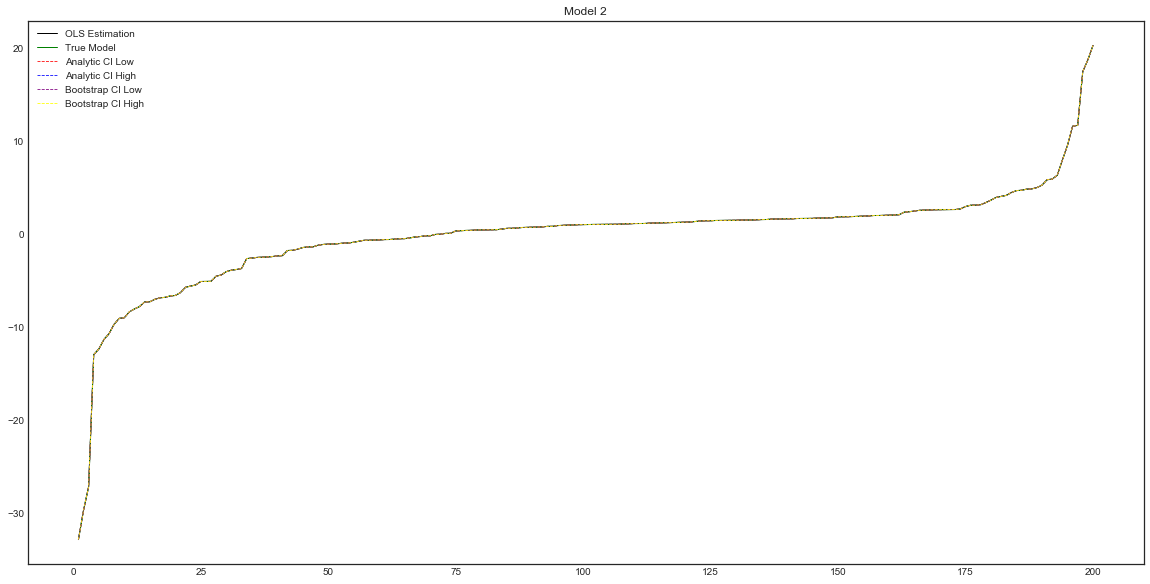

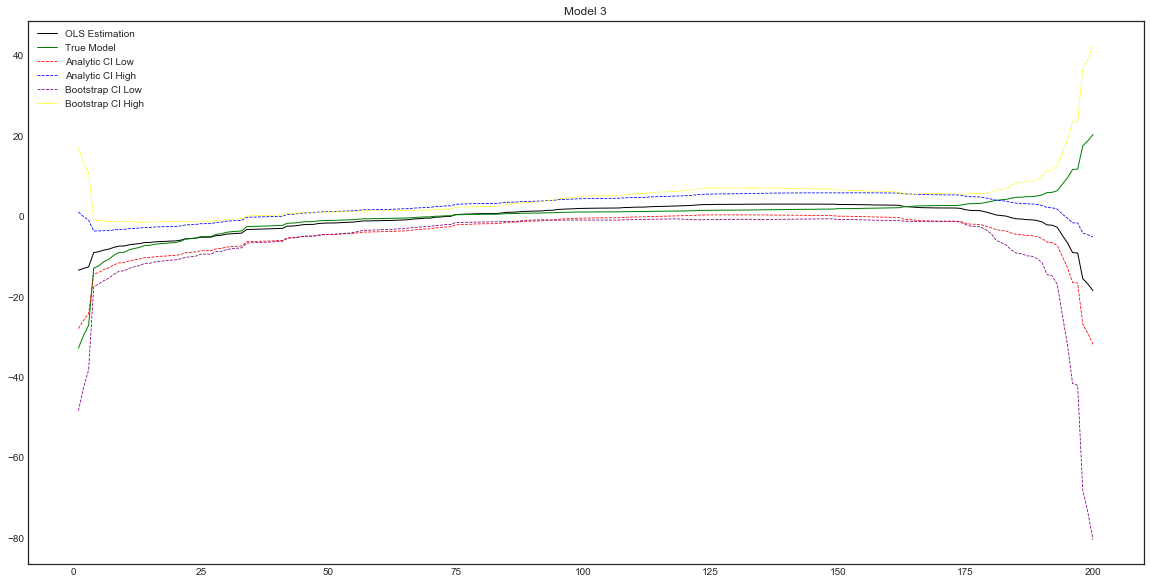

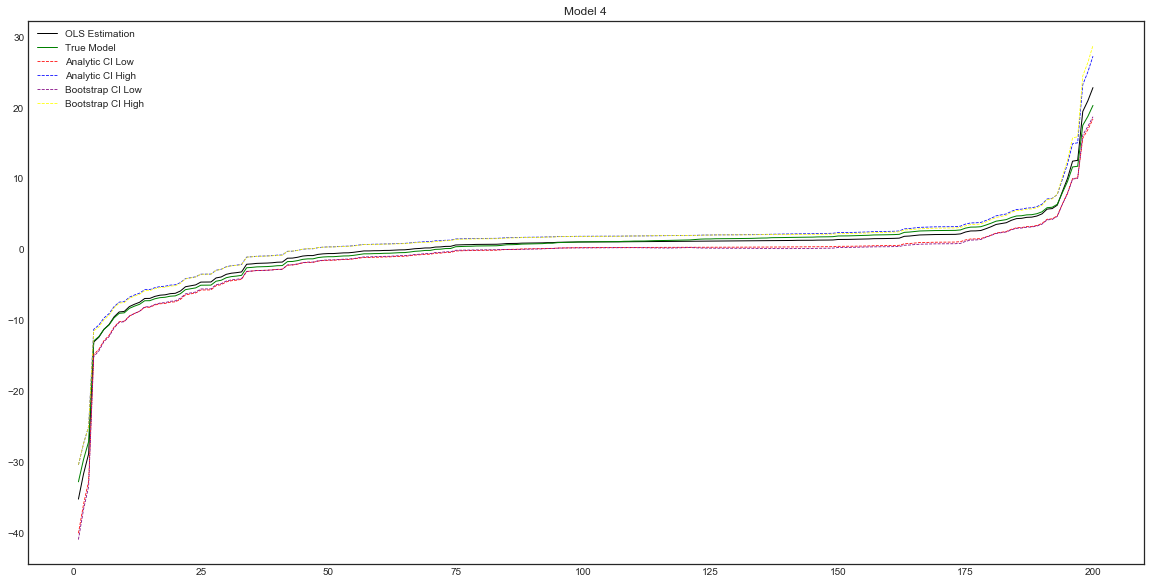

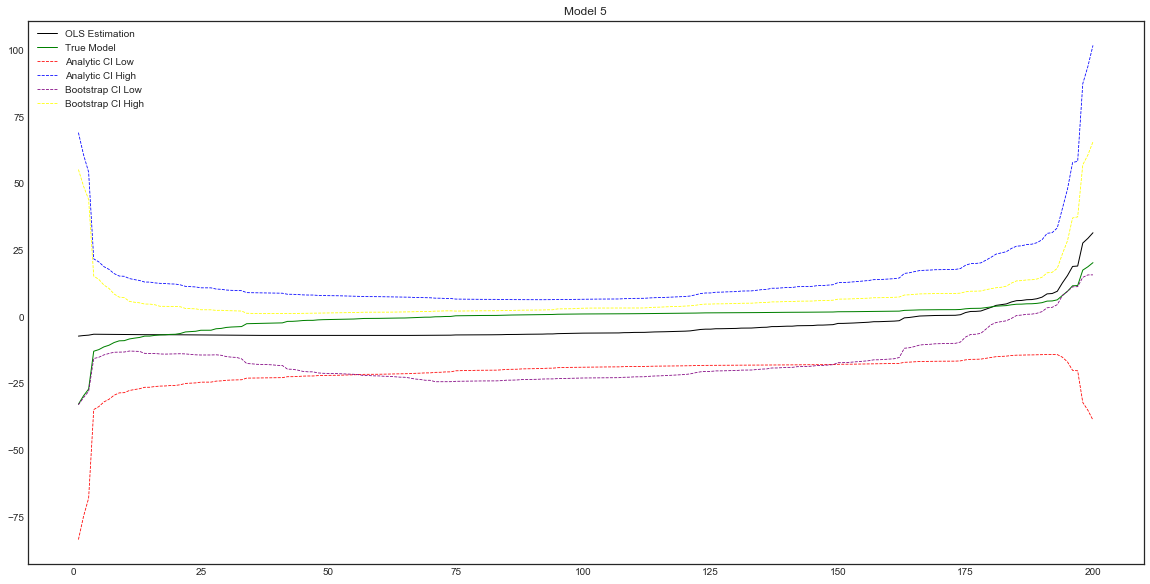

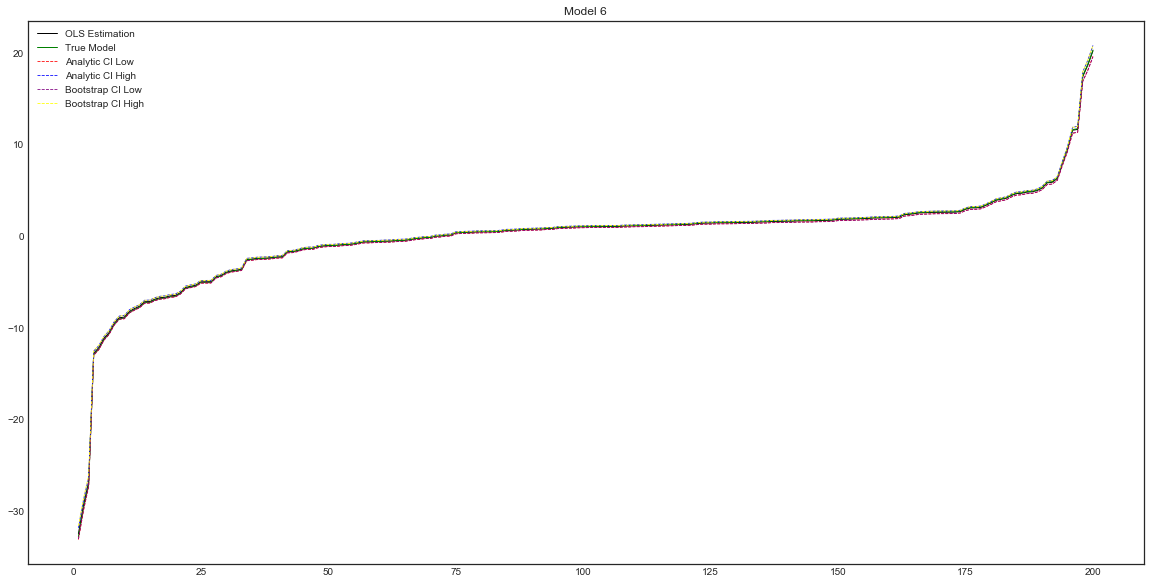

In [19]:
for model in (np.arange(6) + 1):
    plot_models(model, N, B)

In [20]:
# Simulation Study.
def sim_study(rep_times, model):
    """
    Input:
        rep_times (int): How many times for simulation?
        model (int): 1 between 6, see Markdown part.
    Output:
        Report for 6 models.
    """
    sim_longerB = []
    sim_cov_probB = []
    sim_cov_prob_true = []
    sim_int_length = []
    sim_int_lengthB = []
    for _ in np.arange(rep_times):
        report_sim = data_conf(model, N, B)[1]
        sim_longerB.append(report_sim['longerB'])
        sim_cov_probB.append(report_sim['cov_probB'])
        sim_cov_prob_true.append(report_sim['cov_prob_true'])
        sim_int_length.append(report_sim['int_length'])
        sim_int_lengthB.append(report_sim['int_lengthB'])
    
    print('Model', model, '\n')
    print('Avg. Bootstrap CI Longer Ratio: {:.2f}'.format(np.mean(sim_longerB)))
    print('Avg. Cov. Prob. True Model: {:.2f}'.format(np.mean(sim_cov_prob_true)))
    print('Avg. Cov. Prob. Bootstrap: {:.2f}'.format(np.mean(sim_cov_probB)))
    print('Avg. CI Length True Model: {:.2f}'.format(np.mean(sim_int_length)))
    print('Avg. CI Length Bootstrap: {:.2f}'.format(np.mean(sim_int_lengthB)), '\n')

Review our 6 models:
* **Model 1:**　　$\epsilon \sim N(0,10)$
* **Model 2:**　　$\epsilon \sim \Gamma(0.1, 0.01)$ and $\epsilon$ is centered.
* **Model 3:**　　$\epsilon \sim x_2^2 * N(0, 10)$ (Heteroscedastic error term)
* **Model 4:**　　Mixture Model
* **Model 5:**　　$\epsilon \sim t(1)$
* **Model 6:**　　$\epsilon \sim U([-1, 1])$

In [21]:
reps = 100
for model in (np.arange(6) + 1):
    sim_study(reps, model)

Model 1 

Avg. Bootstrap CI Longer Ratio: 0.41
Avg. Cov. Prob. True Model: 0.96
Avg. Cov. Prob. Bootstrap: 0.94
Avg. CI Length True Model: 5.02
Avg. CI Length Bootstrap: 4.99 

Model 2 

Avg. Bootstrap CI Longer Ratio: 0.40
Avg. Cov. Prob. True Model: 0.99
Avg. Cov. Prob. Bootstrap: 0.97
Avg. CI Length True Model: 0.00
Avg. CI Length Bootstrap: 0.00 

Model 3 

Avg. Bootstrap CI Longer Ratio: 0.67
Avg. Cov. Prob. True Model: 0.84
Avg. Cov. Prob. Bootstrap: 0.94
Avg. CI Length True Model: 7.39
Avg. CI Length Bootstrap: 11.32 

Model 4 

Avg. Bootstrap CI Longer Ratio: 0.43
Avg. Cov. Prob. True Model: 0.97
Avg. Cov. Prob. Bootstrap: 0.96
Avg. CI Length True Model: 2.25
Avg. CI Length Bootstrap: 2.24 

Model 5 

Avg. Bootstrap CI Longer Ratio: 0.36
Avg. Cov. Prob. True Model: 0.97
Avg. Cov. Prob. Bootstrap: 0.91
Avg. CI Length True Model: 17.41
Avg. CI Length Bootstrap: 13.33 

Model 6 

Avg. Bootstrap CI Longer Ratio: 0.37
Avg. Cov. Prob. True Model: 0.96
Avg. Cov. Prob. Bootstrap: 0.95
